In [189]:
import pandas as pd
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt

DATE_FORMAT = "%Y-%m-%d"

In [190]:
## Display outlier plot using a boxplot, vertically
def display_outlier_plot(df, column):
    sns.boxplot(y=df[column], orient='v') 
    ## savefig with the columns name
    plt.savefig(f"plots/outliers/{column}.png")
    plt.show()

## Account

In [191]:
## Read dfs
account   = pd.read_csv("dados/pre-processed/account.csv")
loan_dev  = pd.read_csv("dados/pre-processed/loan_dev.csv")
loan_comp = pd.read_csv("dados/pre-processed/loan_comp.csv")
loan   = pd.concat([loan_dev, loan_comp])
loan   = loan[["account_id", "loan_date"]]

In [192]:
## Drop unecessary columns
columns_to_drop = [
    "acc_creation_year",
    "acc_creation_month",
    "acc_creation_day",
]
account.drop(columns=columns_to_drop, axis = 1, inplace = True)

In [193]:
## Replace categorical data with numerical
account["frequency"].replace(
    ["monthly issuance", "weekly issuance", "issuance after transaction"],
    range(0, 3),
    inplace = True
    )

In [194]:
## Merge with loan using account id
df = pd.merge(account, loan, on="account_id", how="left")

In [195]:
## ACCOUNTS WITH NO LOANS WILL HAVE TODAYS LOAN_DATE
## THIS IS NOT AN ISSUE SINCE WE WILL ONLY TRAIN WITH ACCOUNTS THAT ASKED FOR A LOAN
df.fillna("2022-11-21", inplace=True)

In [196]:
df["loan_date"]         = df["loan_date"].apply(lambda x: datetime.strptime(x, DATE_FORMAT))
df["acc_creation_date"] = df["acc_creation_date"].apply(lambda x: datetime.strptime(x, DATE_FORMAT))

In [197]:
## Calculate the difference between loan date and account creation date, in days
df["acc_age_at_loan"] = df.apply(lambda x: x["loan_date"] - x["acc_creation_date"], axis = 1)

## Convert to months
df["acc_age_at_loan"] = df["acc_age_at_loan"].apply(lambda x: math.floor(x.days / 30))

## Replace values greater than 300 with 0 (This are acc that have not made a loan req)
df["acc_age_at_loan"] = df["acc_age_at_loan"].apply(lambda x: 0 if x > 300 else x)

In [198]:
df.drop("loan_date", inplace=True, axis=1)

In [199]:
df.to_csv("dados/cleaned/account.csv", index = False)

## Card

In [200]:
## Read competion and develop dataframes
card_comp = pd.read_csv("dados/pre-processed/card_comp.csv")
card_dev = pd.read_csv("dados/pre-processed/card_dev.csv")

## Concat them
card = pd.concat([card_comp, card_dev])

## Drop type column of disposition
disp_df = pd.read_csv("dados/pre-processed/disp.csv")
disp_df.drop("type", axis=1, inplace=True)

## Merge card with disposition (how=Left so we have all clients and not only those with cards)
card_disp = pd.merge(disp_df, card, on="disp_id", how="left")

## Readability
card_disp.rename(columns = {"type":"type_card"}, inplace=True)

## Replace NaN values with "Other"
card_disp["type_card"].fillna("other", inplace=True)

## Type of card from numerical to categorical
card_disp = pd.get_dummies(card_disp, columns = ['type_card'])

## Function to check whether a person has a card
def has_card(row):
    return 0 if pd.isna(row["card_id"]) else 1

## Apply function to new column
card_disp["has_card"] = card_disp.apply(lambda x: has_card(x), axis = 1)

## Drop columns
card_disp.drop(["card_issued_date", "card_id", "account_id", "client_id"], axis=1, inplace=True)

## Save
card_disp.to_csv("dados/cleaned/card.csv", index=False)

card_disp.head()

,disp_id,card_issued_year,card_issued_month,card_issued_day,type_card_classic,type_card_gold,type_card_junior,type_card_other,has_card
0,1,NaN,NaN,NaN,0,0,0,1,0
1,2,NaN,NaN,NaN,0,0,0,1,0
2,3,NaN,NaN,NaN,0,0,0,1,0
3,4,NaN,NaN,NaN,0,0,0,1,0
4,5,NaN,NaN,NaN,0,0,0,1,0


## Client

In [201]:
## Read useful dataframes
client = pd.read_csv("dados/pre-processed/client.csv")

## Sex from categorical to numerical
client['sex'].replace(['m', 'f'], [0, 1], inplace=True)

def get_age(row):
    collected_date = datetime.strptime("2000-01-01", DATE_FORMAT)
    date = datetime.strptime(row["birthdate"], DATE_FORMAT)
    return collected_date.year - date.year - ((collected_date.month, collected_date.day) < (date.month, date.day))

client["age"] = client.apply(lambda row: get_age(row), axis = 1)

columns_to_drop=[
                "birthdate",
                "birthdate_year",
                "birthdate_month",
                "birthdate_day"
                ]

client.drop(columns=columns_to_drop, axis=1, inplace = True)
## To csv
client.to_csv("dados/cleaned/client.csv", index = False)
client.head()

,client_id,district_id,sex,age
0,1,18,1,29
1,2,1,0,54
2,3,1,1,59
3,4,5,0,43
4,5,5,1,39


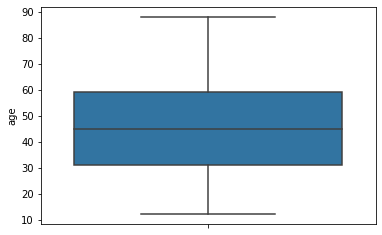

In [202]:
display_outlier_plot(client, "age")
## Save

## Disposition

In [203]:
disp   = pd.read_csv("dados/pre-processed/disp.csv")

def is_account_shared(account_id):
    return 1 if disp["account_id"].value_counts()[account_id] > 1 else 0

## Check if an account is shared
disp["is_shared"] = disp.apply(lambda row: is_account_shared(row["account_id"]), axis = 1)

## Keep only account owners
disp = disp[disp["type"] == "owner"]


## Drop type column
disp.drop("type", axis=1, inplace=True)

## To CSV
disp.to_csv("dados/cleaned/disp.csv", index=False)

disp.head() 

,disp_id,client_id,account_id,is_shared
0,1,1,1,0
1,2,2,2,1
3,4,4,3,1
5,6,6,4,0
6,7,7,5,0


## District

In [204]:
## Read df
dist = pd.read_csv("dados/pre-processed/district.csv")

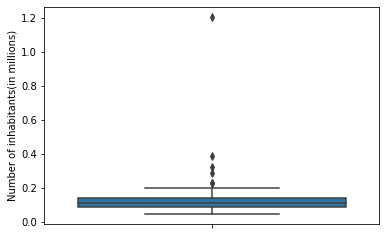

In [205]:
## Plot outliers in number of inhabitants column, vertically
## y label is per mellion
sns.boxplot(y=dist["num_inhab"]/1000000, orient="v")
## Change y axis label
plt.ylabel("Number of inhabitants(in millions)")
## Save
plt.savefig("plots/outliers/num_inhab.png")


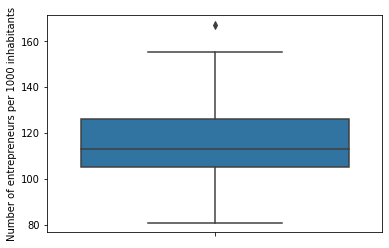

In [206]:
## Plot outliers table of enterp_per_1000, vertically
sns.boxplot(y=dist["enterp_per_1000"], orient="v")
## Change y axis label
plt.ylabel("Number of entrepreneurs per 1000 inhabitants")
## Save
plt.savefig("plots/outliers/enterp_per_1000.png")


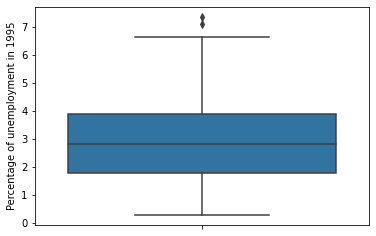

In [207]:
## Plot outliers table of perc_unemploy_95, vertically
sns.boxplot(y=dist["perc_unemploy_95"], orient="v")
## Change y axis label
plt.ylabel("Percentage of unemployment in 1995")
## Save
plt.savefig("plots/outliers/perc_unemploy_95.png")


In [208]:
## Standardize values
dist["num_crimes_95"] = round(dist["num_crimes_95"]/dist["num_inhab"] * 1000, 2)
dist["num_crimes_96"] = round(dist["num_crimes_96"]/dist["num_inhab"] * 1000, 2)

In [209]:
## Find missing values
dist.isna().any()

id                             False
city                           False
region                         False
num_inhab                      False
num_municip_inhab_0_499        False
num_municip_inhab_500_1999     False
num_municip_inhab_2000_9999    False
num_municip_inhab_10000_       False
num_cities                     False
perc_urban_inhab               False
avg_salary                     False
perc_unemploy_95                True
perc_unemploy_96               False
enterp_per_1000                False
num_crimes_95                   True
num_crimes_96                  False
region_zone                     True
dtype: bool

In [210]:
## We have missing values in both perc_unemploy_95 and num_crimes_95. 
## We can deal with it by using the data avaliable in other years
dist["perc_unemploy_95"].fillna(dist["perc_unemploy_96"], inplace=True)
dist["num_crimes_95"].fillna(dist["num_crimes_96"], inplace=True)

## Deal with missing Prague zoning
dist.loc[dist["region"] == "Prague", ["region_zone"]] = "Prague"

dist.isna().any()

id                             False
city                           False
region                         False
num_inhab                      False
num_municip_inhab_0_499        False
num_municip_inhab_500_1999     False
num_municip_inhab_2000_9999    False
num_municip_inhab_10000_       False
num_cities                     False
perc_urban_inhab               False
avg_salary                     False
perc_unemploy_95               False
perc_unemploy_96               False
enterp_per_1000                False
num_crimes_95                  False
num_crimes_96                  False
region_zone                    False
dtype: bool

In [211]:
## Drop some columns
columns_to_drop = [
    'num_municip_inhab_0_499',
    'num_municip_inhab_500_1999', 
    'num_municip_inhab_2000_9999',
    'num_municip_inhab_10000_', 
    'num_cities'
    ]
dist.drop(columns=columns_to_drop, axis = 1, inplace = True)

In [212]:
dist.head()

,id,city,region,num_inhab,perc_urban_inhab,avg_salary,perc_unemploy_95,perc_unemploy_96,enterp_per_1000,num_crimes_95,num_crimes_96,region_zone
0,1,Hl.m. Praha,Prague,1204953,100.0,12541,0.29,0.43,167,71.10,82.25,Prague
1,2,Benesov,Bohemia,88884,46.7,8507,1.67,1.85,132,24.29,30.08,central
2,3,Beroun,Bohemia,75232,41.7,8980,1.95,2.21,111,37.54,37.39,central
3,4,Kladno,Bohemia,149893,67.4,9753,4.64,5.05,109,34.98,39.31,central
4,5,Kolin,Bohemia,95616,51.4,9307,3.85,4.43,118,27.36,31.79,central


<AxesSubplot:>

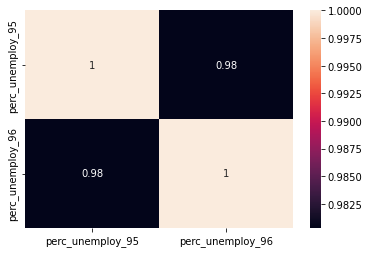

In [213]:
## Plot correlation matrix of perc_unemploy_95 and perc_unemploy_96
sns.heatmap(dist[["perc_unemploy_95", "perc_unemploy_96"]].corr(), annot=True)	

<AxesSubplot:>

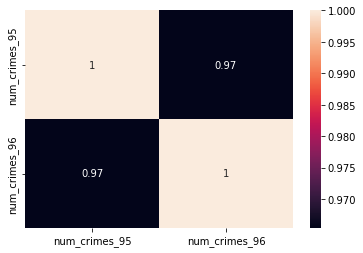

In [214]:
## Plot correlation matrix of num_crimes_95 and num_crimes_96
sns.heatmap(dist[["num_crimes_95", "num_crimes_96"]].corr(), annot=True)

In [215]:
## Since those variables are correlated, let's drop both and keep only the average value
dist["num_crimes"]   = round((dist["num_crimes_95"] + dist["num_crimes_96"]) / 2, 2)
dist["unemployment"] = round((dist["perc_unemploy_95"] + dist["perc_unemploy_96"]) / 2, 2)

## Calculate the unemployment variation in %
dist["unemployment_delta"] = round((dist["perc_unemploy_96"] - dist["perc_unemploy_95"]) / dist["perc_unemploy_95"] , 2)
dist["crimes_delta"]       = round((dist["num_crimes_96"] - dist["num_crimes_95"]) / dist["num_crimes_95"] * 100, 2)


In [216]:
## Drop columns
columns_to_drop = [
    'perc_unemploy_95',
    'perc_unemploy_96',
    'num_crimes_95',
    'num_crimes_96'
]

dist.drop(columns=columns_to_drop, axis = 1, inplace = True)

In [217]:
dist

,id,city,region,num_inhab,perc_urban_inhab,avg_salary,enterp_per_1000,region_zone,num_crimes,unemployment,unemployment_delta,crimes_delta
0,1,Hl.m. Praha,Prague,1204953,100.0,12541,167,Prague,76.68,0.36,0.48,15.68
1,2,Benesov,Bohemia,88884,46.7,8507,132,central,27.18,1.76,0.11,23.84
2,3,Beroun,Bohemia,75232,41.7,8980,111,central,37.47,2.08,0.13,-0.40
3,4,Kladno,Bohemia,149893,67.4,9753,109,central,37.14,4.84,0.09,12.38
4,5,Kolin,Bohemia,95616,51.4,9307,118,central,29.58,4.14,0.15,16.19
...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,Moravia,182027,56.4,8746,90,north,24.14,3.54,0.12,1.76
73,74,Ostrava,Moravia,323870,100.0,10673,100,north,57.32,5.10,0.15,-2.31
74,75,Prerov,Moravia,138032,64.6,8819,99,north,31.04,5.52,0.05,10.87
75,76,Sumperk,Moravia,127369,51.2,8369,107,north,25.68,5.30,0.24,-24.86


In [218]:
dist["region"].replace(["Prague", "Bohemia", "Moravia"], range(0,3), inplace = True)
dist["region_zone"].replace(["north", "west", "south", "east", "central", "Prague"], range(0,6), inplace = True)

In [219]:
dist

,id,city,region,num_inhab,perc_urban_inhab,avg_salary,enterp_per_1000,region_zone,num_crimes,unemployment,unemployment_delta,crimes_delta
0,1,Hl.m. Praha,0,1204953,100.0,12541,167,5,76.68,0.36,0.48,15.68
1,2,Benesov,1,88884,46.7,8507,132,4,27.18,1.76,0.11,23.84
2,3,Beroun,1,75232,41.7,8980,111,4,37.47,2.08,0.13,-0.40
3,4,Kladno,1,149893,67.4,9753,109,4,37.14,4.84,0.09,12.38
4,5,Kolin,1,95616,51.4,9307,118,4,29.58,4.14,0.15,16.19
...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,2,182027,56.4,8746,90,0,24.14,3.54,0.12,1.76
73,74,Ostrava,2,323870,100.0,10673,100,0,57.32,5.10,0.15,-2.31
74,75,Prerov,2,138032,64.6,8819,99,0,31.04,5.52,0.05,10.87
75,76,Sumperk,2,127369,51.2,8369,107,0,25.68,5.30,0.24,-24.86


In [220]:
dist.to_csv("dados/cleaned/district.csv", index = False)

## Loan

In [221]:
loan_dev = pd.read_csv("dados/pre-processed/loan_dev.csv")
loan_comp  = pd.read_csv("dados/pre-processed/loan_comp.csv")

## Drop some columns
columns_to_drop = ["loan_year", "loan_month", "loan_day"]
loan_dev.drop(columns=columns_to_drop, axis = 1, inplace = True)
loan_comp.drop(columns=columns_to_drop, axis = 1, inplace = True)

loan_dev.to_csv("dados/cleaned/loan_dev.csv", index = False)
loan_comp.to_csv("dados/cleaned/loan_comp.csv", index = False)

In [222]:
## Sort by loan date
loan_dev.sort_values(by=["loan_date"], inplace=True, ascending=False)
loan_comp.sort_values(by=["loan_date"], inplace=True)

loan_dev.head()

,loan_id,account_id,amount,duration,payments,status,loan_date
327,7308,11362,129408,24,5392,1,1996-12-27
313,7233,10963,115812,36,3217,1,1996-12-25
251,6805,8972,45024,48,938,1,1996-12-21
86,5625,3189,222180,60,3703,-1,1996-12-15
256,6818,9030,155616,48,3242,1,1996-12-12


In [223]:
loan_comp.head()

,loan_id,account_id,amount,duration,payments,status,loan_date
143,5895,4473,93960,60,1566,NaN,1997-01-03
322,7122,10365,260640,36,7240,NaN,1997-01-04
184,6173,5724,232560,48,4845,NaN,1997-01-08
181,6142,5591,221880,60,3698,NaN,1997-01-21
61,5358,2018,38520,12,3210,NaN,1997-01-21


## Transaction

In [224]:
## Load training(dev) and testing(comp) datasets
trans_dev = pd.read_csv("dados/pre-processed/trans_dev.csv")
trans_dev.drop(["trans_day", "trans_year", "trans_month"], axis = 1, inplace = True)
loan_dev = pd.read_csv("dados/pre-processed/loan_dev.csv", usecols=["duration", "amount", "status", "account_id", "loan_date"])

trans_comp  = pd.read_csv("dados/pre-processed/trans_comp.csv")
trans_comp.drop(["trans_day", "trans_year", "trans_month"], axis = 1, inplace = True)
loan_comp = pd.read_csv("dados/pre-processed/loan_comp.csv", usecols=["duration", "amount", "status", "account_id", "loan_date"])

C:\Users\veris\AppData\Local\Temp\ipykernel_22700\86729310.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv("dados/pre-processed/trans_dev.csv")


In [225]:
def clean_data(df):
    ## Consider nan operations as others
    df["operation"].fillna("other", inplace=True)

    ## Consider empty symbols as other symbols
    df["k_symbol"].replace("", "other", inplace=True)
    df["k_symbol"].replace(" ", "other", inplace=True)

    ## Consider nan symbols as none
    df["k_symbol"].fillna("none", inplace=True)

    ## Consider empty bank as other bank
    df["bank"].replace("", "other", inplace=True)


    ## Table that says whether a payment has a characterization
    df["has_symbol"] = df.apply(lambda x: 0 if x["k_symbol"] == "none" else 1, axis = 1)

    ## Table that says whether a payment is of type: sanction
    df["is_sanction"] = df.apply(lambda x: 1 if x["k_symbol"] == "sanction interest if negative balance" else 0, axis = 1)

    return df

In [226]:
def create_features(trans, loan):
    df = pd.merge(trans, loan, on="account_id", suffixes=('_trans', '_loan'))
    newdf = df.copy()

    ############## -> Check if an account only made transactions to account with NAN values <-##############
    df["account"].fillna(0, inplace=True)
    df["to_NAN"] = df.apply(lambda x : 1 if x["account"] == 0 else 0, axis = 1)

    df = df.groupby(['account_id'], as_index=False).agg(
                                only_to_na = pd.NamedAgg(column='to_NAN', aggfunc='min')
                                )
    
    ############## -> Check balance min, avg and max in the N months preceding a loan request <-##############
    ## Convert dates to comparable format
    newdf["trans_date"] = newdf["trans_date"].apply(lambda x: datetime.strptime(x, DATE_FORMAT))
    newdf["loan_date"] = newdf["loan_date"].apply(lambda x: datetime.strptime(x, DATE_FORMAT))

    ## Drop rows with transactions after loan
    newdf[newdf["loan_date"] > newdf["trans_date"]]

    # -> Check the balance of an account in N months before a loan request
    MONTHS = 12
    newdf["diff_days"]   = newdf.apply(lambda x: (x["loan_date"] - x["trans_date"]).days, axis = 1)
    newdf["diff_months"] = newdf.apply(lambda x: math.floor(x["diff_days"] / 30), axis = 1)
    newdf = newdf[newdf["diff_months"] < MONTHS]

    newdf = newdf[["account_id", "balance", "is_sanction"]]

    newdf = newdf.groupby(['account_id'], as_index=False).agg(
                                min_balance = pd.NamedAgg(column='balance', aggfunc='min'),
                                avg_balance = pd.NamedAgg(column='balance', aggfunc='mean'), 
                                max_balance = pd.NamedAgg(column='balance', aggfunc='max'),
                                sanctions   = pd.NamedAgg(column='is_sanction', aggfunc='sum'))

    ## Check if the accound reached a negative balance
    newdf["negative_balance"] = newdf.apply(lambda x: 1 if x["min_balance"] < 0 else 0, axis = 1)
    return pd.merge(newdf, df, on='account_id')

In [227]:
trans_comp  = clean_data(trans_comp)
trans_dev   = clean_data(trans_dev)

In [228]:
trans_comp  = create_features(trans_comp, loan_comp)
trans_dev   = create_features(trans_dev, loan_dev)

In [229]:
trans_comp.to_csv("dados/cleaned/trans_comp.csv", index=False)
trans_dev.to_csv("dados/cleaned/trans_dev.csv", index=False)

In [243]:
ready_dev = pd.read_csv("dados/ready/dev.csv")
ready_comp = pd.read_csv("dados/ready/comp.csv")

In [246]:
## print all columns
pd.set_option('display.max_columns', None)

ready_dev.head()

,loan_id,amount,duration,payments,status,acc_age_at_loan,is_shared,sex,age,num_inhab,perc_urban_inhab,avg_salary,enterp_per_1000,num_crimes,unemployment,unemployment_delta,crimes_delta,type_card_classic,type_card_gold,type_card_junior,has_card,min_balance,avg_balance,max_balance,sanctions,negative_balance,only_to_na
0,4959,80952,24,3373,0,10,1,0,54,1204953,100.0,12541,167,76.68,0.36,0.48,15.68,0,0,0,0,1100.0,32590.624074,67529.6,0,0,0
1,4961,30276,12,2523,1,12,0,1,60,103347,67.0,9104,123,22.52,1.79,0.37,2.38,0,0,0,0,715.0,25871.173684,58157.5,0,0,0
2,4973,165960,24,6915,0,18,0,1,55,93931,56.9,8427,107,20.16,1.33,0.37,2.11,0,0,0,0,17413.7,50696.435417,100151.7,0,0,0
3,4996,88440,12,7370,0,5,1,1,54,128118,85.3,9317,97,53.94,6.78,0.09,-1.11,0,0,0,0,200.0,62778.090323,103239.0,0,0,1
4,5002,104808,12,8734,0,6,1,0,60,125832,48.3,8512,102,17.28,3.82,0.17,-6.44,0,0,0,0,500.0,38709.830000,57865.3,0,0,0
